In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [6]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [7]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [8]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [9]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [10]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [11]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [12]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [13]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [14]:
province_pops.iloc[0]['Pop']

15176115

In [15]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# Download Data

## Download case data

In [16]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD       EC       FS        GP       KZN       LP       MP  \
date                                                                           
2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311      0.0      0.0       5.0       7.0      0.0      0.0   
...              ...      ...      ...       ...       ...      ...      ...   
2020-09-05  20200905  86755.0  39486.0  212564.0  114646.0  13665.0  24976.0   
2020-09-06  20200906  86849.0  39781.0  212898.0  114824.0  13734.0  25076.0   
2020-09-07  20200907  86868.0  39986.0  213087.0  114904.0  13769.0  25125.0   
2020-09-08  20200908  86926.0  40154.0  213333.0  115081.0  13797.0  25198.0   
2020-09-09  20200909  87040.0  40456.0  213741.0  115372.0  13900.0  25311.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-09-05  11718.0  26092.0  106982.0      0.0  636884   
2020-09-06  11923.0  26245.0  107187.0      0.0  638517   
2020-09-07  12085.0  26294.0  107244.0      0.0  639362   
2020-09-08  12222.0  26399.0  107331.0      0.0  640441   
2020-09-09  12407.0  26580.0  107624.0      0.0  642431   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-09-05  https://sacoronavirus.co.za/2020/09/05/update-...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[187 rows x 13 columns]

In [17]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-09-09 00:00:00'))

In [18]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03',
               '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07',
               '2020-09-08', '2020-09-09'],
              dtype='datetime64[ns]', length=189, freq='D')

In [19]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD       EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0      0.0   
...              ...      ...      ...       ...       ...      ...      ...   
2020-09-05  20200905  86755.0  39486.0  212564.0  114646.0  13665.0  24976.0   
2020-09-06  20200906  86849.0  39781.0  212898.0  114824.0  13734.0  25076.0   
2020-09-07  20200907  86868.0  39986.0  213087.0  114904.0  13769.0  25125.0   
2020-09-08  20200908  86926.0  40154.0  213333.0  115081.0  13797.0  25198.0   
2020-09-09  20200909  87040.0  40456.0  213741.0  115372.0  13900.0  25311.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-09-05  11718.0  26092.0  106982.0      0.0     636884   
2020-09-06  11923.0  26245.0  107187.0      0.0     638517   
2020-09-07  12085.0  26294.0  107244.0      0.0     639362   
2020-09-08  12222.0  26399.0  107331.0      0.0     640441   
2020-09-09  12407.0  26580.0  107624.0      0.0     642431   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-09-05  https://sacoronavirus.co.za/2020/09/05/update-...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 13 columns]

In [20]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date  YYYYMMDD       EC       FS        GP       KZN       LP  \
0   2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0   
1   2020-03-06  20200305      0.0      0.0       0.0       1.0      0.0   
2   2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0   
3   2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0   
4   2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0   
..         ...       ...      ...      ...       ...       ...      ...   
184 2020-09-05  20200905  86755.0  39486.0  212564.0  114646.0  13665.0   
185 2020-09-06  20200906  86849.0  39781.0  212898.0  114824.0  13734.0   
186 2020-09-07  20200907  86868.0  39986.0  213087.0  114904.0  13769.0   
187 2020-09-08  20200908  86926.0  40154.0  213333.0  115081.0  13797.0   
188 2020-09-09  20200909  87040.0  40456.0  213741.0  115372.0  13900.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0          1   
1        0.0      0.0      0.0       0.0      0.0          1   
2        0.0      0.0      0.0       0.0      0.0          2   
3        0.0      0.0      0.0       0.0      0.0          3   
4        0.0      0.0      0.0       0.0      0.0          7   
..       ...      ...      ...       ...      ...        ...   
184  24976.0  11718.0  26092.0  106982.0      0.0     636884   
185  25076.0  11923.0  26245.0  107187.0      0.0     638517   
186  25125.0  12085.0  26294.0  107244.0      0.0     639362   
187  25198.0  12222.0  26399.0  107331.0      0.0     640441   
188  25311.0  12407.0  26580.0  107624.0      0.0     642431   

                                                source  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
184  https://sacoronavirus.co.za/2020/09/05/update-...  
185  https://twitter.com/nicd_sa/status/13026906284...  
186  https://twitter.com/nicd_sa/status/13030543821...  
187  https://twitter.com/nicd_sa/status/13034201194...  
188  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 14 columns]

## Download death data

In [21]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC   FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                    
2020-03-27  20200327     0    0     0     0    0    0    0    0     1   
2020-03-28  20200328     0    0     0     1    0    0    0    0     1   
2020-03-30  20200330     0    1     0     1    0    0    0    0     1   
2020-03-31  20200331     0    1     1     2    0    0    0    0     1   
2020-04-03  20200403     0    1     1     6    0    0    0    0     1   
...              ...   ...  ...   ...   ...  ...  ...  ...  ...   ...   
2020-09-05  20200905  2979  776  3789  2263  214  378  145  275  3960   
2020-09-06  20200906  2986  785  3813  2294  214  416  145  275  3961   
2020-09-07  20200907  2998  792  3818  2319  257  416  145  285  3974   
2020-09-08  20200908  3007  798  3833  2346  257  416  150  285  3994   
2020-09-09  20200909  3012  806  3860  2356  257  416  150  295  4016   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-09-05        0  14779  https://twitter.com/nicd_sa/status/13023151403...  
2020-09-06        0  14889  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07        0  15004  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08        0  15086  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09        0  15168  https://twitter.com/nicd_sa/status/13037732622...  

[163 rows x 13 columns]

In [22]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC     FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN    NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...    ...     ...     ...    ...    ...    ...   
2020-09-05  20200905.0  2979.0  776.0  3789.0  2263.0  214.0  378.0  145.0   
2020-09-06  20200906.0  2986.0  785.0  3813.0  2294.0  214.0  416.0  145.0   
2020-09-07  20200907.0  2998.0  792.0  3818.0  2319.0  257.0  416.0  145.0   
2020-09-08  20200908.0  3007.0  798.0  3833.0  2346.0  257.0  416.0  150.0   
2020-09-09  20200909.0  3012.0  806.0  3860.0  2356.0  257.0  416.0  150.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-09-05  275.0  3960.0      0.0  14779.0   
2020-09-06  275.0  3961.0      0.0  14889.0   
2020-09-07  285.0  3974.0      0.0  15004.0   
2020-09-08  285.0  3994.0      0.0  15086.0   
2020-09-09  295.0  4016.0      0.0  15168.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-09-05  https://twitter.com/nicd_sa/status/13023151403...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 13 columns]

In [23]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC     FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0    0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...    ...     ...     ...    ...    ...    ...   
2020-09-05  20200905.0  2979.0  776.0  3789.0  2263.0  214.0  378.0  145.0   
2020-09-06  20200906.0  2986.0  785.0  3813.0  2294.0  214.0  416.0  145.0   
2020-09-07  20200907.0  2998.0  792.0  3818.0  2319.0  257.0  416.0  145.0   
2020-09-08  20200908.0  3007.0  798.0  3833.0  2346.0  257.0  416.0  150.0   
2020-09-09  20200909.0  3012.0  806.0  3860.0  2356.0  257.0  416.0  150.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-09-05  275.0  3960.0      0.0    14779.0   
2020-09-06  275.0  3961.0      0.0    14889.0   
2020-09-07  285.0  3974.0      0.0    15004.0   
2020-09-08  285.0  3994.0      0.0    15086.0   
2020-09-09  295.0  4016.0      0.0    15168.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-09-05  https://twitter.com/nicd_sa/status/13023151403...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 13 columns]

In [24]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC     FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0    0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...    ...     ...     ...    ...    ...   
184 2020-09-05  20200905.0  2979.0  776.0  3789.0  2263.0  214.0  378.0   
185 2020-09-06  20200906.0  2986.0  785.0  3813.0  2294.0  214.0  416.0   
186 2020-09-07  20200907.0  2998.0  792.0  3818.0  2319.0  257.0  416.0   
187 2020-09-08  20200908.0  3007.0  798.0  3833.0  2346.0  257.0  416.0   
188 2020-09-09  20200909.0  3012.0  806.0  3860.0  2356.0  257.0  416.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
184  145.0  275.0  3960.0      0.0    14779.0   
185  145.0  275.0  3961.0      0.0    14889.0   
186  145.0  285.0  3974.0      0.0    15004.0   
187  150.0  285.0  3994.0      0.0    15086.0   
188  150.0  295.0  4016.0      0.0    15168.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
184  https://twitter.com/nicd_sa/status/13023151403...  
185  https://twitter.com/nicd_sa/status/13026906284...  
186  https://twitter.com/nicd_sa/status/13030543821...  
187  https://twitter.com/nicd_sa/status/13034201194...  
188  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 14 columns]

## Download recovery data

In [25]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD     EC     FS      GP     KZN     LP     MP    NC     NW  \
date                                                                            
2020-04-17  20200417      9     71     479      96     18      9    10      6   
2020-04-18  20200418      9     71     479      96     18      9    10      6   
2020-04-19  20200419      9     71     479      96     18      9    10      6   
2020-04-20  20200420     15     74     545     151     21     14    13      6   
2020-04-21  20200421     15     74     545     151     21     14    13      6   
...              ...    ...    ...     ...     ...    ...    ...   ...    ...   
2020-09-05  20200905  82233  27129  186731  101797  12702  23475  7573  20554   
2020-09-06  20200906  82233  27129  187301  101989  12782  23610  8717  21033   
2020-09-07  20200907  82842  27129  187987  102318  12874  23766  8933  21530   
2020-09-08  20200908  82842  27129  188367  102474  12952  23917  8956  21530   
2020-09-09  20200909  82842  27129  188987  103437  12989  23917  9075  21673   

               WC  UNKNOWN   total  \
date                                 
2020-04-17    205        0     903   
2020-04-18    205        0     903   
2020-04-19    205        0     903   
2020-04-20    216        0    1055   
2020-04-21    216        0    1055   
...           ...      ...     ...   
2020-09-05  99010        0  561204   
2020-09-06  99097        0  563891   
2020-09-07  99176        0  566555   
2020-09-08  99562        0  567729   
2020-09-09  99886        0  569935   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-09-05  https://twitter.com/nicd_sa/status/13023151403...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[140 rows x 13 columns]

In [26]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD       EC       FS        GP       KZN       LP  \
2020-03-05         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN      NaN      NaN       NaN       NaN      NaN   
...                ...      ...      ...       ...       ...      ...   
2020-09-05  20200905.0  82233.0  27129.0  186731.0  101797.0  12702.0   
2020-09-06  20200906.0  82233.0  27129.0  187301.0  101989.0  12782.0   
2020-09-07  20200907.0  82842.0  27129.0  187987.0  102318.0  12874.0   
2020-09-08  20200908.0  82842.0  27129.0  188367.0  102474.0  12952.0   
2020-09-09  20200909.0  82842.0  27129.0  188987.0  103437.0  12989.0   

                 MP      NC       NW       WC  UNKNOWN     total  \
2020-03-05      NaN     NaN      NaN      NaN      NaN       NaN   
2020-03-06      NaN     NaN      NaN      NaN      NaN       NaN   
2020-03-07      NaN     NaN      NaN      NaN      NaN       NaN   
2020-03-08      NaN     NaN      NaN      NaN      NaN       NaN   
2020-03-09      NaN     NaN      NaN      NaN      NaN       NaN   
...             ...     ...      ...      ...      ...       ...   
2020-09-05  23475.0  7573.0  20554.0  99010.0      0.0  561204.0   
2020-09-06  23610.0  8717.0  21033.0  99097.0      0.0  563891.0   
2020-09-07  23766.0  8933.0  21530.0  99176.0      0.0  566555.0   
2020-09-08  23917.0  8956.0  21530.0  99562.0      0.0  567729.0   
2020-09-09  23917.0  9075.0  21673.0  99886.0      0.0  569935.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-09-05  https://twitter.com/nicd_sa/status/13023151403...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 13 columns]

In [27]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD       EC       FS        GP       KZN       LP  \
2020-03-05         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0      0.0      0.0       0.0       0.0      0.0   
...                ...      ...      ...       ...       ...      ...   
2020-09-05  20200905.0  82233.0  27129.0  186731.0  101797.0  12702.0   
2020-09-06  20200906.0  82233.0  27129.0  187301.0  101989.0  12782.0   
2020-09-07  20200907.0  82842.0  27129.0  187987.0  102318.0  12874.0   
2020-09-08  20200908.0  82842.0  27129.0  188367.0  102474.0  12952.0   
2020-09-09  20200909.0  82842.0  27129.0  188987.0  103437.0  12989.0   

                 MP      NC       NW       WC  UNKNOWN  Total RSA  \
2020-03-05      0.0     0.0      0.0      0.0      0.0        0.0   
2020-03-06      0.0     0.0      0.0      0.0      0.0        0.0   
2020-03-07      0.0     0.0      0.0      0.0      0.0        0.0   
2020-03-08      0.0     0.0      0.0      0.0      0.0        0.0   
2020-03-09      0.0     0.0      0.0      0.0      0.0        0.0   
...             ...     ...      ...      ...      ...        ...   
2020-09-05  23475.0  7573.0  20554.0  99010.0      0.0   561204.0   
2020-09-06  23610.0  8717.0  21033.0  99097.0      0.0   563891.0   
2020-09-07  23766.0  8933.0  21530.0  99176.0      0.0   566555.0   
2020-09-08  23917.0  8956.0  21530.0  99562.0      0.0   567729.0   
2020-09-09  23917.0  9075.0  21673.0  99886.0      0.0   569935.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-09-05  https://twitter.com/nicd_sa/status/13023151403...  
2020-09-06  https://twitter.com/nicd_sa/status/13026906284...  
2020-09-07  https://twitter.com/nicd_sa/status/13030543821...  
2020-09-08  https://twitter.com/nicd_sa/status/13034201194...  
2020-09-09  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 13 columns]

In [28]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD       EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0      0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0      0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0      0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0      0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0      0.0      0.0       0.0       0.0      0.0   
..         ...         ...      ...      ...       ...       ...      ...   
184 2020-09-05  20200905.0  82233.0  27129.0  186731.0  101797.0  12702.0   
185 2020-09-06  20200906.0  82233.0  27129.0  187301.0  101989.0  12782.0   
186 2020-09-07  20200907.0  82842.0  27129.0  187987.0  102318.0  12874.0   
187 2020-09-08  20200908.0  82842.0  27129.0  188367.0  102474.0  12952.0   
188 2020-09-09  20200909.0  82842.0  27129.0  188987.0  103437.0  12989.0   

          MP      NC       NW       WC  UNKNOWN  Total RSA  \
0        0.0     0.0      0.0      0.0      0.0        0.0   
1        0.0     0.0      0.0      0.0      0.0        0.0   
2        0.0     0.0      0.0      0.0      0.0        0.0   
3        0.0     0.0      0.0      0.0      0.0        0.0   
4        0.0     0.0      0.0      0.0      0.0        0.0   
..       ...     ...      ...      ...      ...        ...   
184  23475.0  7573.0  20554.0  99010.0      0.0   561204.0   
185  23610.0  8717.0  21033.0  99097.0      0.0   563891.0   
186  23766.0  8933.0  21530.0  99176.0      0.0   566555.0   
187  23917.0  8956.0  21530.0  99562.0      0.0   567729.0   
188  23917.0  9075.0  21673.0  99886.0      0.0   569935.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
184  https://twitter.com/nicd_sa/status/13023151403...  
185  https://twitter.com/nicd_sa/status/13026906284...  
186  https://twitter.com/nicd_sa/status/13030543821...  
187  https://twitter.com/nicd_sa/status/13034201194...  
188  https://twitter.com/nicd_sa/status/13037732622...  

[189 rows x 14 columns]

## Download testing data
Only for country

In [29]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-09-04    3765700.0
2020-09-05    3783823.0
2020-09-06    3800190.0
2020-09-07    3808949.0
2020-09-08    3821162.0
Name: cumulative_tests, Length: 193, dtype: float64

In [30]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-09-05    3783823.0
2020-09-06    3800190.0
2020-09-07    3808949.0
2020-09-08    3821162.0
2020-09-09    3821162.0
Freq: D, Name: cumulative_tests, Length: 189, dtype: float64

In [31]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-09-05    3783823.0
2020-09-06    3800190.0
2020-09-07    3808949.0
2020-09-08    3821162.0
2020-09-09    3821162.0
Freq: D, Name: Total RSA, Length: 189, dtype: float64

In [32]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
184 2020-09-05  3783823.0
185 2020-09-06  3800190.0
186 2020-09-07  3808949.0
187 2020-09-08  3821162.0
188 2020-09-09  3821162.0

[189 rows x 2 columns]

# Analysis Per Province

In [33]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [34]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [35]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA       EC       FS        GP       KZN       LP       MP  \
Date                                                                            
2020-03-05        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-06        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-07        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-08        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-09        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
...               ...      ...      ...       ...       ...      ...      ...   
2020-09-05   575983.0  85212.0  27905.0  190520.0  104060.0  12916.0  23853.0   
2020-09-06   578780.0  85219.0  27914.0  191114.0  104283.0  12996.0  24026.0   
2020-09-07   581559.0  85840.0  27921.0  191805.0  104637.0  13131.0  24182.0   
2020-09-08   582815.0  85849.0  27927.0  192200.0  104820.0  13209.0  24333.0   
2020-09-09   585103.0  85854.0  27935.0  192847.0  105793.0  13246.0  24333.0   

                NC       NW        WC  
Date                                   
2020-03-05     0.0      0.0       0.0  
2020-03-06     0.0      0.0       0.0  
2020-03-07     0.0      0.0       0.0  
2020-03-08     0.0      0.0       0.0  
2020-03-09     0.0      0.0       0.0  
...            ...      ...       ...  
2020-09-05  7718.0  20829.0  102970.0  
2020-09-06  8862.0  21308.0  103058.0  
2020-09-07  9078.0  21815.0  103150.0  
2020-09-08  9106.0  21815.0  103556.0  
2020-09-09  9225.0  21968.0  103902.0  

[189 rows x 10 columns]

In [36]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA       EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...      ...      ...       ...       ...      ...   
184 2020-09-05  -575983.0 -85212.0 -27905.0 -190520.0 -104060.0 -12916.0   
185 2020-09-06  -578780.0 -85219.0 -27914.0 -191114.0 -104283.0 -12996.0   
186 2020-09-07  -581559.0 -85840.0 -27921.0 -191805.0 -104637.0 -13131.0   
187 2020-09-08  -582815.0 -85849.0 -27927.0 -192200.0 -104820.0 -13209.0   
188 2020-09-09  -585103.0 -85854.0 -27935.0 -192847.0 -105793.0 -13246.0   

          MP      NC       NW        WC  
0       -0.0    -0.0     -0.0      -0.0  
1       -0.0    -0.0     -0.0      -0.0  
2       -0.0    -0.0     -0.0      -0.0  
3       -0.0    -0.0     -0.0      -0.0  
4       -0.0    -0.0     -0.0      -0.0  
..       ...     ...      ...       ...  
184 -23853.0 -7718.0 -20829.0 -102970.0  
185 -24026.0 -8862.0 -21308.0 -103058.0  
186 -24182.0 -9078.0 -21815.0 -103150.0  
187 -24333.0 -9106.0 -21815.0 -103556.0  
188 -24333.0 -9225.0 -21968.0 -103902.0  

[189 rows x 11 columns]

In [37]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA      EC       FS       GP      KZN     LP      MP  \
0   2020-03-05        1.0     0.0      0.0      0.0      1.0    0.0     0.0   
1   2020-03-06        1.0     0.0      0.0      0.0      1.0    0.0     0.0   
2   2020-03-07        2.0     0.0      0.0      1.0      1.0    0.0     0.0   
3   2020-03-08        3.0     0.0      0.0      1.0      2.0    0.0     0.0   
4   2020-03-09        7.0     0.0      0.0      1.0      6.0    0.0     0.0   
..         ...        ...     ...      ...      ...      ...    ...     ...   
184 2020-09-05    60901.0  1543.0  11581.0  22044.0  10586.0  749.0  1123.0   
185 2020-09-06    59737.0  1630.0  11867.0  21784.0  10541.0  738.0  1050.0   
186 2020-09-07    57803.0  1028.0  12065.0  21282.0  10267.0  638.0   943.0   
187 2020-09-08    57626.0  1077.0  12227.0  21133.0  10261.0  588.0   865.0   
188 2020-09-09    57328.0  1186.0  12521.0  20894.0   9579.0  654.0   978.0   

         NC      NW      WC  
0       0.0     0.0     0.0  
1       0.0     0.0     0.0  
2       0.0     0.0     0.0  
3       0.0     0.0     0.0  
4       0.0     0.0     0.0  
..      ...     ...     ...  
184  4000.0  5263.0  4012.0  
185  3061.0  4937.0  4129.0  
186  3007.0  4479.0  4094.0  
187  3116.0  4584.0  3775.0  
188  3182.0  4612.0  3722.0  

[189 rows x 11 columns]

In [38]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [39]:
analysis_all = pd.concat([analysis_cases, analysis_active, analysis_recovery, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
1885 2020-09-05         WC  3960.0  Deaths
1886 2020-09-06         WC  3961.0  Deaths
1887 2020-09-07         WC  3974.0  Deaths
1888 2020-09-08         WC  3994.0  Deaths
1889 2020-09-09         WC  4016.0  Deaths

[7560 rows x 4 columns]

In [40]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [41]:
template_h = '%{y}'

## Plot analysis for provinces

In [42]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [43]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [44]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [45]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [46]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
184 2020-09-05  Total RSA  3783823.0  Tests
185 2020-09-06  Total RSA  3800190.0  Tests
186 2020-09-07  Total RSA  3808949.0  Tests
187 2020-09-08  Total RSA  3821162.0  Tests
188 2020-09-09  Total RSA  3821162.0  Tests

[945 rows x 4 columns]

In [47]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data', line_shape='spline')
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [48]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [49]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [50]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
188 2020-09-09  Total RSA   642431.0      Cases
188 2020-09-09  Total RSA    57328.0     Active
188 2020-09-09  Total RSA   569935.0  Recovered
188 2020-09-09  Total RSA    15168.0     Deaths
188 2020-09-09  Total RSA  3821162.0      Tests

In [51]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [52]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('642,431', 57328.0, 569935.0, 15168.0, 3821162.0)

## Plot analysis per province

In [53]:
max_states = max(analysis_states['Value']) * 1.05
max_states

224428.05000000002

In [54]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [55]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [56]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
1875 2020-09-05         WC -136.0  Active
1876 2020-09-06         WC  117.0  Active
1877 2020-09-07         WC  -35.0  Active
1878 2020-09-08         WC -319.0  Active
1879 2020-09-09         WC  -53.0  Active

[1880 rows x 4 columns]

In [57]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA     EC     FS     GP    KZN    LP     MP     NC     NW  \
2020-03-06        1.0    0.0    0.0    0.0    1.0   0.0    0.0    0.0    0.0   
2020-03-07        1.0    0.0    0.0    0.0    1.0   0.0    0.0    0.0    0.0   
2020-03-08        2.0    0.0    0.0    1.0    1.0   0.0    0.0    0.0    0.0   
2020-03-09        2.0    0.0    0.0    1.0    1.0   0.0    0.0    0.0    0.0   
2020-03-10        3.0    0.0    0.0    1.0    1.0   0.0    0.0    0.0    0.0   
...               ...    ...    ...    ...    ...   ...    ...    ...    ...   
2020-09-05     1763.0  108.0  296.0  397.0  259.0  74.0  106.0  203.0  142.0   
2020-09-06     1580.0   93.0  272.0  344.0  221.0  66.0   97.0  192.0  127.0   
2020-09-07     1443.0   80.0  251.0  312.0  197.0  60.0   89.0  177.0  119.0   
2020-09-08     1395.0   73.0  241.0  297.0  191.0  58.0   87.0  171.0  120.0   
2020-09-09     1416.0   74.0  238.0  301.0  197.0  61.0   85.0  167.0  125.0   

               WC  
2020-03-06    0.0  
2020-03-07    0.0  
2020-03-08    0.0  
2020-03-09    0.0  
2020-03-10    0.0  
...           ...  
2020-09-05  181.0  
2020-09-06  167.0  
2020-09-07  157.0  
2020-09-08  158.0  
2020-09-09  167.0  

[188 rows x 10 columns]

In [58]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province  Value            Data
0    2020-03-06  Total RSA    1.0  Cases Smoothed
1    2020-03-07  Total RSA    1.0  Cases Smoothed
2    2020-03-08  Total RSA    2.0  Cases Smoothed
3    2020-03-09  Total RSA    2.0  Cases Smoothed
4    2020-03-10  Total RSA    3.0  Cases Smoothed
...         ...        ...    ...             ...
1875 2020-09-05         WC  181.0  Cases Smoothed
1876 2020-09-06         WC  167.0  Cases Smoothed
1877 2020-09-07         WC  157.0  Cases Smoothed
1878 2020-09-08         WC  158.0  Cases Smoothed
1879 2020-09-09         WC  167.0  Cases Smoothed

[1880 rows x 4 columns]

In [59]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [60]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
183 2020-09-05  Total RSA  101.0  Deaths
184 2020-09-06  Total RSA  110.0  Deaths
185 2020-09-07  Total RSA  115.0  Deaths
186 2020-09-08  Total RSA   82.0  Deaths
187 2020-09-09  Total RSA   82.0  Deaths

[940 rows x 4 columns]

In [61]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06       36.0
2020-03-07       41.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2020-09-05    18123.0
2020-09-06    16367.0
2020-09-07     8759.0
2020-09-08    12213.0
2020-09-09        0.0
Freq: D, Name: Total RSA, Length: 188, dtype: float64

In [62]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province    Value   Data
0   2020-03-06  Total RSA     36.0  Tests
1   2020-03-07  Total RSA     41.0  Tests
2   2020-03-08  Total RSA      0.0  Tests
3   2020-03-09  Total RSA      0.0  Tests
4   2020-03-10  Total RSA      0.0  Tests
..         ...        ...      ...    ...
183 2020-09-05  Total RSA  18123.0  Tests
184 2020-09-06  Total RSA  16367.0  Tests
185 2020-09-07  Total RSA   8759.0  Tests
186 2020-09-08  Total RSA  12213.0  Tests
187 2020-09-09  Total RSA      0.0  Tests

[188 rows x 4 columns]

In [63]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province    Value   Data
0   2020-03-06  Total RSA      0.0  Cases
1   2020-03-07  Total RSA      1.0  Cases
2   2020-03-08  Total RSA      1.0  Cases
3   2020-03-09  Total RSA      4.0  Cases
4   2020-03-10  Total RSA      0.0  Cases
..         ...        ...      ...    ...
183 2020-09-05  Total RSA  18123.0  Tests
184 2020-09-06  Total RSA  16367.0  Tests
185 2020-09-07  Total RSA   8759.0  Tests
186 2020-09-08  Total RSA  12213.0  Tests
187 2020-09-09  Total RSA      0.0  Tests

[1128 rows x 4 columns]

## Plot daily change for South Africa

In [64]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [65]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [66]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [67]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [68]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [69]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
146 2020-09-04            47831.0              85382.0          14415.0   
147 2020-09-05            47899.0              85485.0          14436.0   
148 2020-09-06            47974.0              85599.0          14448.0   
149 2020-09-07            48005.0              85653.0          14464.0   
150 2020-09-08            48062.0              85729.0          14484.0   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases     Total  
146         46175.0           13688.0                 4695.0  212186.0  
147         46318.0           13729.0                 4697.0  212564.0  
148         46417.0           13760.0                 4700.0  212898.0  
149         46492.0           13776.0                 4697.0  213087.0  
150         46567.0           13794.0                 4697.0  213333.0

# Rt Model 1

## Data Import

In [70]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-08-06  1.18     1.30    1.04
          2020-08-07  0.97     1.09    0.83
          2020-08-08  0.82     0.93    0.66
          2020-08-09  0.48     0.60    0.32
          2020-08-10  0.40     0.52    0.23

[1030 rows x 3 columns]

In [71]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.35    0.79
1            EC 2020-04-12  3.35     5.13    1.25
2            EC 2020-04-13  3.12     4.54    1.56
3            EC 2020-04-14  2.72     3.88    1.41
4            EC 2020-04-15  2.27     3.29    1.12
...         ...        ...   ...      ...     ...
1025  Total RSA 2020-08-06  1.18     1.30    1.04
1026  Total RSA 2020-08-07  0.97     1.09    0.83
1027  Total RSA 2020-08-08  0.82     0.93    0.66
1028  Total RSA 2020-08-09  0.48     0.60    0.32
1029  Total RSA 2020-08-10  0.40     0.52    0.23

[1030 rows x 5 columns]

## Setup Rt

In [72]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
885   Total RSA 2020-03-19  2.11     3.70    0.22
886   Total RSA 2020-03-20  2.50     3.73    1.09
887   Total RSA 2020-03-21  2.75     3.71    1.67
888   Total RSA 2020-03-22  2.87     3.67    1.99
889   Total RSA 2020-03-23  2.97     3.64    2.20
...         ...        ...   ...      ...     ...
1025  Total RSA 2020-08-06  1.18     1.30    1.04
1026  Total RSA 2020-08-07  0.97     1.09    0.83
1027  Total RSA 2020-08-08  0.82     0.93    0.66
1028  Total RSA 2020-08-09  0.48     0.60    0.32
1029  Total RSA 2020-08-10  0.40     0.52    0.23

[145 rows x 5 columns]

In [73]:
X0rt1 = state_single.iloc[1]['Date']
X0rt1

Timestamp('2020-03-20 00:00:00')

In [74]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('10 August 2020', 0.4)

## Latest Rt summary

In [75]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         0.23
FS         0.62
GP         0.35
KZN        0.69
LP         0.75
MP         0.16
NC         0.89
NW         0.28
Total RSA  0.40
WC         0.43

In [76]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [77]:
state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [78]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [79]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0         EC 2020-04-11  3.84     6.35    0.79
1         EC 2020-04-12  3.35     5.13    1.25
2         EC 2020-04-13  3.12     4.54    1.56
3         EC 2020-04-14  2.72     3.88    1.41
4         EC 2020-04-15  2.27     3.29    1.12
..       ...        ...   ...      ...     ...
880       WC 2020-08-06  0.85     1.20    0.48
881       WC 2020-08-07  0.89     1.22    0.50
882       WC 2020-08-08  0.81     1.14    0.42
883       WC 2020-08-09  0.52     0.86    0.14
884       WC 2020-08-10  0.43     0.77    0.06

[885 rows x 5 columns]

In [80]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [81]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [82]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [83]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [84]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  1.971    2.232   1.696     176.132             0.000
1   2020-02-27  1.969    2.201   1.699       2.505             0.000
2   2020-02-28  1.969    2.203   1.713      35.519             0.000
3   2020-02-29  1.956    2.184   1.681      67.684             0.000
4   2020-03-01  1.947    2.198   1.741      75.329             0.000
..         ...    ...      ...     ...         ...               ...
192 2020-09-05  0.865    1.021   0.682    2206.214          3158.634
193 2020-09-06  0.870    1.048   0.703    2161.740          3078.333
194 2020-09-07  0.873    1.044   0.688    2120.197          3000.616
195 2020-09-08  0.866    1.045   0.671    2081.616          2925.473
196 2020-09-09  0.866    1.085   0.705    2045.962          2852.928

[197 rows x 6 columns]

In [85]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [126]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

0.866

In [87]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-09-09 00:00:00'), '09 September 2020')

In [88]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [89]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [127]:
Pc = 1-(1/rt2)
Pc * 100

-15.473441108545028

In [128]:
immune = country_pop * Pc
immune

-9094518.106235562

## Rt trends model

In [129]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date   Cases
0   2020-03-05       1
1   2020-03-06       1
2   2020-03-07       2
3   2020-03-08       3
4   2020-03-09       7
..         ...     ...
184 2020-09-05  636884
185 2020-09-06  638517
186 2020-09-07  639362
187 2020-09-08  640441
188 2020-09-09  642431

[189 rows x 2 columns]

In [130]:
from datetime import timedelta, date

In [94]:
f = 60

In [95]:
f2 = 30

In [96]:
diff = cases_df['Cases'].diff()

In [97]:
d = diff.values[-1]
d

1990.0

In [132]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3,
 1.25,
 1.2,
 1.15,
 1.1,
 1.085,
 1.075,
 1.05,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9,
 0.866,
 0.85,
 0.8,
 0.705,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [139]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date          Cases    R
0  2020-03-05       1.000000  1.5
1  2020-03-06       1.000000  1.5
2  2020-03-07       2.000000  1.5
3  2020-03-08       3.000000  1.5
4  2020-03-09       7.000000  1.5
..        ...            ...  ...
0  2020-11-04  642652.111111  0.1
0  2020-11-05  642652.111111  0.1
0  2020-11-06  642652.111111  0.1
0  2020-11-07  642652.111111  0.1
0  2020-11-08  642652.111111  0.1

[6225 rows x 3 columns]

In [140]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.085
1  2020-03-06       1.000000  1.085
2  2020-03-07       2.000000  1.085
3  2020-03-08       3.000000  1.085
4  2020-03-09       7.000000  1.085
..        ...            ...    ...
0  2020-11-04  647186.762697  0.705
0  2020-11-05  647186.762701  0.705
0  2020-11-06  647186.762704  0.705
0  2020-11-07  647186.762707  0.705
0  2020-11-08  647186.762708  0.705

[747 rows x 3 columns]

In [141]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

647186

In [142]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.1%'

In [143]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [144]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

4211058.375221351

In [147]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [106]:
increasing_forecast = future_projections.query(f"R > 1")

In [107]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [108]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [109]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [110]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [111]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [112]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-08-06  1.18     1.30    1.04
          2020-08-07  0.97     1.09    0.83
          2020-08-08  0.82     0.93    0.66
          2020-08-09  0.48     0.60    0.32
          2020-08-10  0.40     0.52    0.23

[1030 rows x 3 columns]

In [113]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [114]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

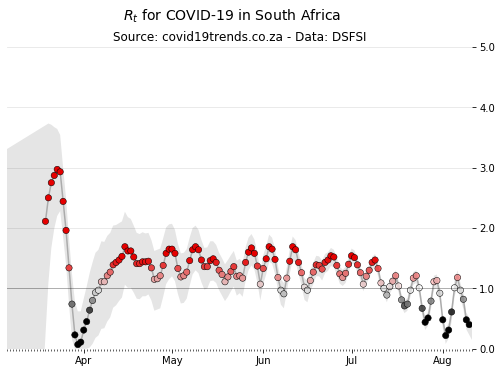

In [115]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [116]:
states_rt_i = states_all_rt_i.loc[state_filter]

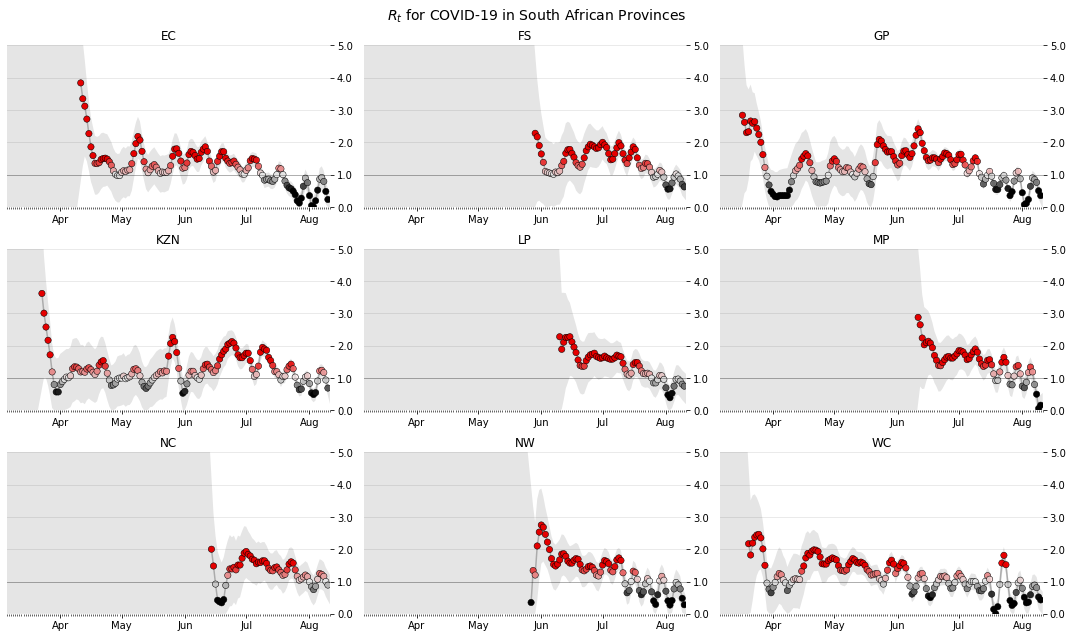

In [117]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [118]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [119]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         0.23     0.57    0.00
FS         0.62     0.91    0.27
GP         0.35     0.58    0.10
KZN        0.69     0.88    0.46
LP         0.75     1.18    0.25
MP         0.16     0.48    0.00
NC         0.89     1.32    0.41
NW         0.28     0.68    0.00
Total RSA  0.40     0.52    0.23
WC         0.43     0.77    0.06

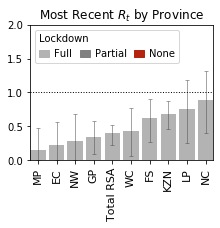

In [120]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

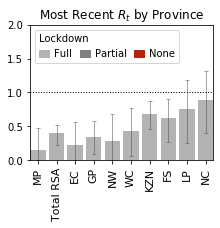

In [121]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

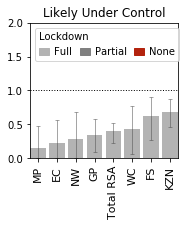

In [122]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

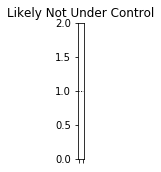

In [123]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()